# Modeling kanban boards with markov chains

In this notebook we will train and test a markov chain model on data extracted from a team's kanban board.
This is inspired by the talk from 'Forecasting in Complex Systems' Olga Heismann on the LKCE 2018. See the following links for reference:
* [Vimeo](https://vimeo.com/302850933)
* [Slideshare](https://de.slideshare.net/lkce/olga-heismann-forcasting-in-complex-systems)

Together with this notebook you will find data that was extracted from the boards of two teams.
You can use you own data if you use the following format:
```
0,0,0,1,2,2,4,5
0,0,1,2,3,5
...
```
Where every line represents a ticket. The numbers a separated by a `,` and represent the column the ticket was in on a specific date. Line `0,0,1,2,3,5` means that the ticket was in colum `0` for 2 days, then 1 day in column 2 and 3, and then ending in column 5.

### Setup
Setting up dependencies and some helper methods.

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plot
from numpy.linalg import inv
from functools import reduce
from statistics import mean
import random

def firstPositiveIndex(l):
    for (index, e) in enumerate(l):
        if e>=0:
            return index

def getNextState(row, currentState):
    r = random.random()
    monteCarlo = reduce(lambda l, e: l + [e+l[-1]] if l else [e], row, [])
    return firstPositiveIndex(np.array(monteCarlo)-r)

def dayUntilDone(tM, startState, numberOfRuns):
    runs = []
    absorbingStates = np.nonzero(tM == 1)[0] # doesn't matter if the take axis 0 or 1 as they both are equal
    for _ in range(numberOfRuns):
        currentState = startState
        daysPassed = 0
        while not currentState in absorbingStates:
            row = tM[currentState]
            currentState = getNextState(row, currentState)
            daysPassed += 1
        runs.append(daysPassed)
    return mean(runs)


def toTransitionMatrix(model, numStates):
    result = np.zeros((numStates, numStates))
    keys = range(numStates)
    absorbingStateCount = 0
    for y in keys:
        sumCount = sum(model[y].values())
        if sumCount == 0:
            result[y][y] = 1 # absorbing transition 
            absorbingStateCount += 1
            continue
        result[y] = [model[y][x]/sumCount for x in keys]
    
    transientStateCount = result.shape[0]-absorbingStateCount
    sMatrix = result[0:transientStateCount,0:transientStateCount]
    qMatrix = inv(np.identity(transientStateCount) - sMatrix)
    
    return (result, qMatrix)

flatten = lambda l: [item for sublist in l for item in sublist]


     |████████████████████████████████| 17.3MB 3.9MB/s eta 0:00:01    |███████▏                        | 3.9MB 1.6MB/s eta 0:00:09     |███████████████████████████▉    | 15.1MB 4.5MB/s eta 0:00:01     |█████████████████████████████   | 15.7MB 4.5MB/s eta 0:00:01     |██████████████████████████████  | 16.2MB 4.5MB/s eta 0:00:01
     |████████████████████████████████| 13.1MB 9.5MB/s eta 0:00:01    |███                             | 1.2MB 1.8MB/s eta 0:00:07     |███████████████████████         | 9.5MB 1.8MB/s eta 0:00:03     |█████████████████████████▋      | 10.5MB 9.5MB/s eta 0:00:01
     |████████████████████████████████| 71kB 22.4MB/s eta 0:00:01
     |████████████████████████████████| 92kB 11.2MB/s eta 0:00:01


# Applying the Markov-Chain model to the board data

In [2]:
with open("team1-cycletime.csv") as f:
    dataRows = f.readlines()
dataSet = list(map(lambda row: list(map(int, row.strip("\n").split(","))), dataRows))

NUMBER_OF_STATES = len(set(flatten(dataSet)))

print("We will create a markov chain with {} states.".format(NUMBER_OF_STATES))

We will create a markov chain with 6 states.


In [3]:

TRAINING_SET_RATIO = 0.7

# random.shuffle(dataSet) # shuffle the data if you want training and testing sets to be randomized.

split = int(len(dataSet)*TRAINING_SET_RATIO)
trainingSet = dataSet[:split]
testingSet = dataSet[split:]

print("We have a training set of {} tickets and a test set of {} tickets ({} total)."
      .format(split, len(dataSet)-split, len(dataSet)))

We have a training set of 273 tickets and a test set of 118 tickets (391 total).


Transition matrix:
[[0.92 0.05 0.02 0.   0.   0.01]
 [0.   0.88 0.08 0.02 0.01 0.02]
 [0.   0.   0.89 0.04 0.01 0.06]
 [0.   0.   0.   0.69 0.04 0.26]
 [0.   0.   0.   0.   0.66 0.34]
 [0.   0.   0.   0.   0.   1.  ]]


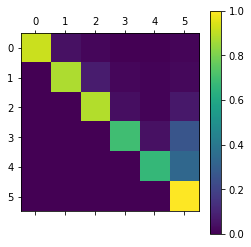

In [4]:
model = defaultdict(Counter)
for row in trainingSet:
    for i in range(len(row) - 1):
        state = row[i]
        nextState = row[i + 1]
        model[state][nextState] += 1

(matrix, Q) = toTransitionMatrix(model, NUMBER_OF_STATES)
print("Transition matrix:")
print(matrix.round(decimals=2))

plot.matshow(matrix);
plot.colorbar()
plot.show()

## Q&A

Now that we have our model trained, we can use it to make predictions for our board.

### How will a board look after a specific amount of time?

In [5]:
days = 7
board = [0] * NUMBER_OF_STATES
board[1] = 5
print("Q: How will this board: '{}' look after {} days?".format(board, days))
matrixAfterSomeTime = np.linalg.matrix_power(matrix, days)
borderAfterSomeTime = (board @ matrixAfterSomeTime)
print("A: {}".format(borderAfterSomeTime))

Q: How will this board: '[0, 5, 0, 0, 0, 0]' look after 7 days?
A: [0.         2.00606051 1.24022767 0.26240357 0.13033737 1.36097088]


### When will a work item in a specific state be done?

[23.36609652 15.26558091 10.35994126  3.68926818  2.9787234 ]


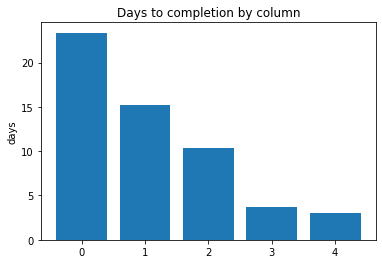

In [6]:
daysToCompletion = np.sum(Q, 1)
print(daysToCompletion)

xValues = range(len(daysToCompletion))
plot.bar(xValues, daysToCompletion)
plot.ylabel('days')
plot.title('Days to completion by column')
plot.show()

Verifying that our result is correct with the Monte-Carlo method:

In [7]:
simulationCount = 10000
stateToTest = 0
print("MonteCarlo with {} runs:".format(simulationCount))
print("Average days it takes to complete an item in state {}: {}".format(stateToTest, dayUntilDone(matrix, 0, simulationCount)))

MonteCarlo with 10000 runs:
Average days it takes to complete an item in state 0: 23.4415


## Are we accurate?
We test if we are accurate by calculating some error. For comparison we calculate the error for a predecition where our answers is always "the board will look the same like yesterday". Feel free to test against other models or prediction methods.

In [8]:
days = 7
startingState = 0 # 0 if all tickets should start in the first column
def getBoardAfterDays(data, numberOfDaysInFuture):
    board = [0] * matrix.shape[0]
    for row in data:
        startingIndex = firstPositiveIndex(np.array(row) - startingState)
        stateAfterDays = row[startingIndex+numberOfDaysInFuture] if startingIndex+numberOfDaysInFuture < len(row) else row[-1]
        board[stateAfterDays]+=1
    return board
testingBoard=getBoardAfterDays(testingSet, 0)
print("How will this board: '{}' look after {} days?".format(testingBoard, days))
def testWherePrediction(numberOfDaysInFuture):
    testResult = getBoardAfterDays(testingSet, numberOfDaysInFuture)
    matrixAfterSomeTime = np.linalg.matrix_power(matrix, numberOfDaysInFuture)
    markovResult = (testingBoard @ matrixAfterSomeTime).round()
    print("\nTest result: " + str(testResult))
    print("Markov result: " + str(markovResult))
    print("\nError: " + str(1/len(testResult)*sum(map(abs, testResult - markovResult))))
    print("Error if we would say nothing changes: " + str(1/len(markovResult)*sum(map(abs, testingBoard - markovResult))))
testWherePrediction(days)

How will this board: '[56, 29, 18, 1, 1, 13]' look after 7 days?

Test result: [27, 18, 15, 6, 0, 52]
Markov result: [31. 21. 21.  4.  2. 39.]

Error: 5.0
Error if we would say nothing changes: 11.0
